In [ ]:
#the purpose of this cell is to connect google colab with google drive 
from google.colab import drive
drive.mount('/content/drive')

# Import the necessary librairys that will need in all the notebook

In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


import warnings
import time

warnings.simplefilter("ignore")
# Définir la taille des figurines
sns.set(rc={'figure.figsize':(16,6)})

#NAS pour trouver meilleure architecture, meilleure combinaison de paramétres

#  Pre-traitement des données

In [191]:
# lire les données qu'on souhaite utilisées pour l'apprentissage
data = pd.read_csv('/content/drive/MyDrive/Dossier_sans_titre/train.csv', sep=",",index_col=False)
data.head(-1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


#### Valeurs manquantes

L'imputation des données est la pratique consistant à remplacer les données manquantes par des valeurs de substitution.<br>Il peut y avoir une multitude de procédés de substitution qui peuvent être utilisés. <br>

In [192]:
#nombre de valeurs manquantes par variable
sum_NaN_data = data.isnull().sum()
print (sum_NaN_data)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [193]:
#moyenne des valeurs manquante par variable
mean_NaN_data = data.isnull().mean()
print (mean_NaN_data)

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64


Nous remarquons que notre datasets necéssite un prétraitement avant procédé à la phase d l'apprentissage, ( Y'a des valeurs manquante, des données inutiles, ...). Donc on va les netoyer et les preparer avec des methodes adequats.

#### Definition des variables

- Survived (survécu 0 = No, 1 = Yes)
- Pclass (Ticket class 1 = 1st, 2 = 2nd, 3 = 3rd)
- Sex (Genre)
- Age (Age en années)
- SibSp (# de frères et sœurs / conjoints à bord du Titanic)
- Parch (# de parents/enfants à bord du Titanic)
- Ticket (Numéro de Ticket)
- fare (Prix du billet passager)
- Cabin (Numéro de Cabin)
- Embarked(Port d'embarquement: C = Cherbourg, Q = Queenstown, S = Southampton)


on verifie si nos données contient des *doubelons*. En utilisant la fonction *unique()* .

In [194]:
len(data['PassengerId'].unique())

891

Il semble qu'il n'y ait pas d'entrées en double basées sur l'ID des passagers. Nous avons au total 891 passagers dans l'ensemble de données.



### Visualisation des données

#### ci-dessous un aperçu de nos données 

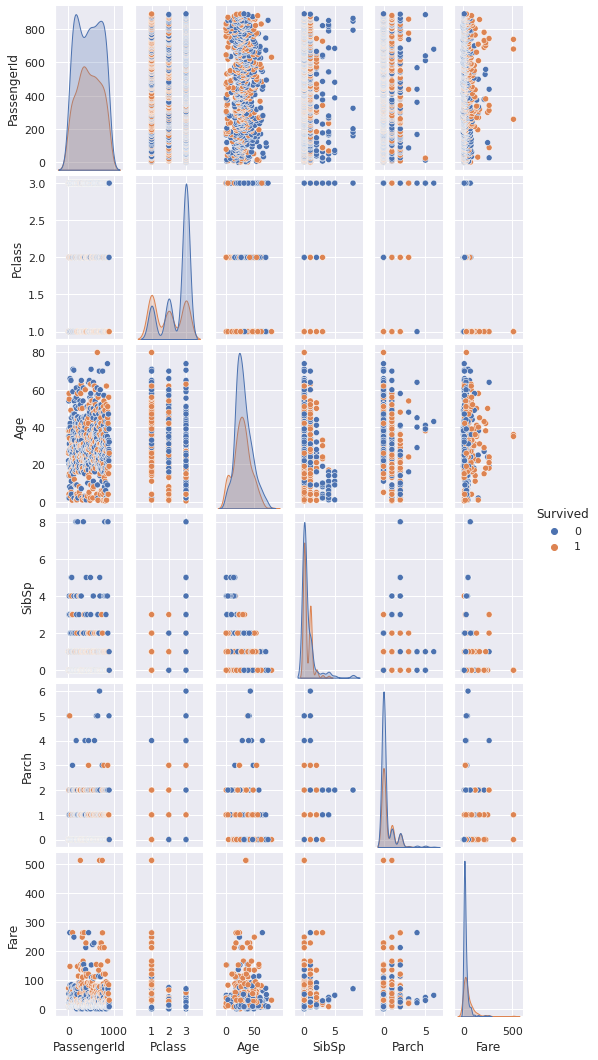

In [195]:
sns.pairplot(data, aspect = 0.5, hue='Survived')
plt.show()

Visualisation de pourcentage de sexe des passagers 

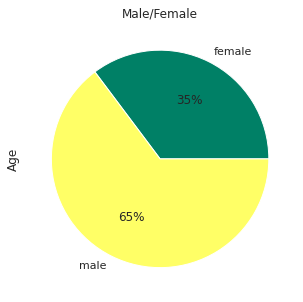

In [196]:
data.groupby(by='Sex').size().plot.pie(figsize=(5, 5), ylabel='Age', title='Male/Female', autopct='%1.0f%%', cmap='summer')

Visualisation de l'age des passagers

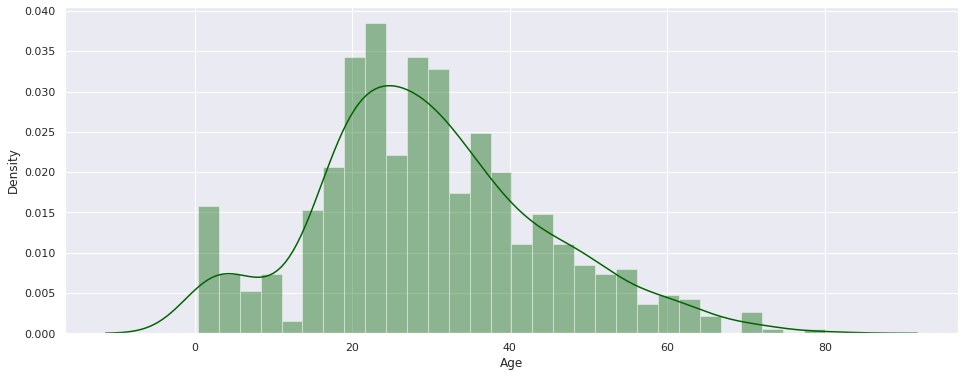

In [197]:
data.Embarked.fillna(data.Embarked.mode()[0], inplace = True)
sns.distplot(data['Age'].dropna(),color='darkgreen',bins=30)

Text(0.5, 1.0, 'Données manquantes')

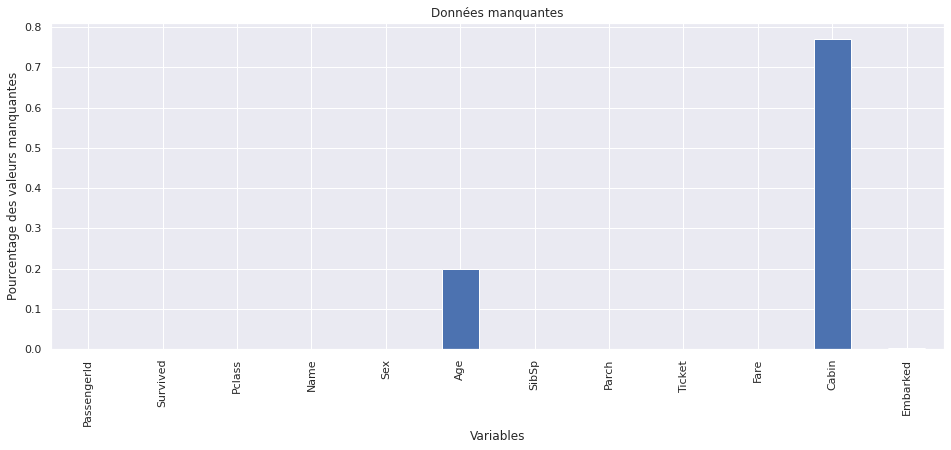

In [198]:
# Les pourcentages de données manquantes :
mean_NaN_data.plot.bar(figsize=(16,6))
plt.ylabel('Pourcentage des valeurs manquantes')
plt.xlabel('Variables')
plt.title('Données manquantes')

On remarque le manque de plusieurs valeurs pour les deux colonnes Age et Cabin, par contre les autres colonnes n'ont pas de valeurs manquantes a part la colonne Embarked qui a deux valeurs manquantes.

### Traitement de données

Dans cette partie nous allons preparer nos données pour l'apprentissage :<br><br>
   - Suppression des observations/colonnes <br><br>
   - Effectuer une imputation moyenne ou médiane<br><br>
   - Imputation par catégorie la plus fréquente<br><br>
   - Remplacer les valeurs manquantes par un nombre arbitraire<br><br>
   - Remplacer les valeurs manquantes par une valeur à la fin de la distribution<br><br>

D'apres la visulisation de notre dataset, on remarque que les colonnes 'Name' et 'Ticket' sont inutiles dans notre etude, donc on va les supprimer.

In [199]:
data.drop(['Name','Ticket'], axis=1, inplace=True)



In [200]:
# Passer des valeurs categorials aux valeurs numériques
data['Sex'] = data['Sex'].replace([['male'],['female']],[0,1])
data['Embarked'] = data['Sex'].replace([['C'],['Q'],['S']],[1,2,3])

In [201]:
# Visualiser le dataset apres la suppression des colonnes inutiles
data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,0,22.0,1,0,7.2500,NaN,0
1,2,1,1,1,38.0,1,0,71.2833,C85,1
2,3,1,3,1,26.0,0,0,7.9250,NaN,1
3,4,1,1,1,35.0,1,0,53.1000,C123,1
4,5,0,3,0,35.0,0,0,8.0500,NaN,0


- #### Variable Embarked


In [202]:
# Values count
data['Embarked'].value_counts()

0    577
1    314
Name: Embarked, dtype: int64

In [203]:
data.Embarked.isnull().sum()

0

Étant donné que cette variable n'avait que deux valeurs manquantes et le plus grand nombre de passagers ont embarqué depuis la ville S,la probabilité d'embarquement depuis S est plus élevée. <br><br>
Donc, nous remplissons les valeurs manquantes avec S.<br><br> 
Cependant, au lieu de mettre manuellement S, nous trouverions le 'mode' de la variable et remplacerions les valeurs manquantes par celui-ci.<br><br>
Le mode est l'élément le plus fréquent dans une série.

In [204]:
# Rempalcer les valeurs nulles par le mode 
data.Embarked.fillna(data.Embarked.mode()[0], inplace = True)
# Verification des valeurs manquantes dans la colonne Embarked
data.Embarked.isnull().sum()

0

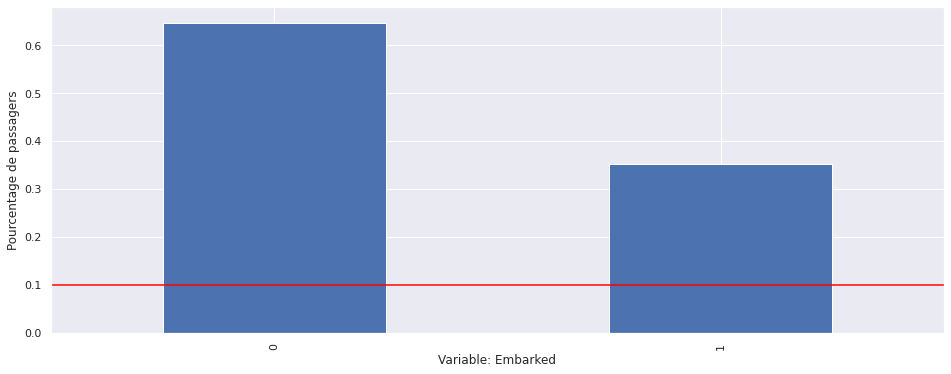

In [205]:
label_freq = data['Embarked'].value_counts() / len(data)
label_freq
# faisons un graphique avec les fréquences de catégorie
fig = label_freq.sort_values(ascending=False).plot.bar()

# ajouter une ligne pour signaler la limite de fréquence de 10 %
fig.axhline(y=0.10, color='red')

fig.set_ylabel('Pourcentage de passagers')
fig.set_xlabel('Variable: Embarked')
plt.show()

- #### Variable Cabin

In [206]:
# Values count
data['Cabin'].value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

In [207]:
data.Cabin.isnull().sum()

687

Etant donné que la colonne « cabin » contient beaucoup de données manquantes. 
Nous allons classer toutes ces valeurs manquantes dans une classe différente 'NULL'. 
Nous allons assigné cette valeur à toutes les lignes manquantes.

In [208]:
data["Cabin"].fillna("Missing", inplace=True)
data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,0,22.0,1,0,7.2500,Missing,0
1,2,1,1,1,38.0,1,0,71.2833,C85,1
2,3,1,3,1,26.0,0,0,7.9250,Missing,1
3,4,1,1,1,35.0,1,0,53.1000,C123,1
4,5,0,3,0,35.0,0,0,8.0500,Missing,0


- ### Variable
Pour l'etude de cette colonne nous allons créer une nouvelle variable pour les tranches d'age.


Text(0.5, 1.0, 'age')

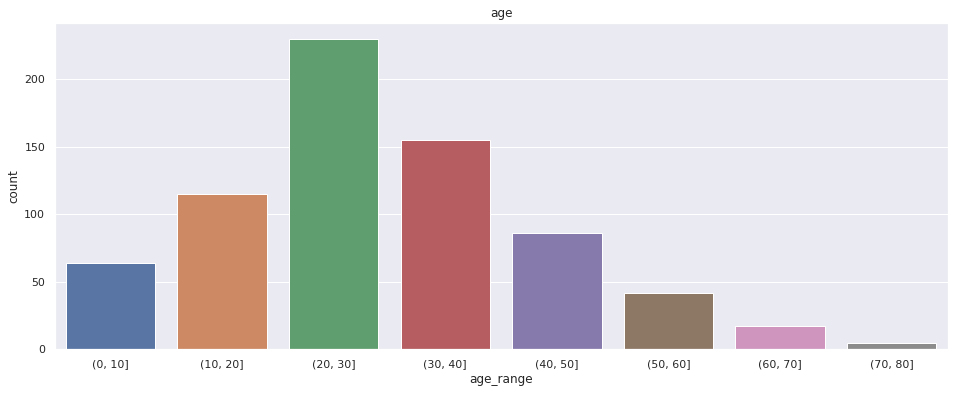

In [209]:
# créer nouvelle variable pour les tranches d'age
data['age_range'] = pd.cut(data.Age,[0,10,20,30,40,50,60,70,80])
# plot de tranches d'age
x = sns.countplot(x = "age_range", data = data)
x.set_title("age")

In [210]:
# determiner la median de la colonne age
age_median = data.Age.median()
# Remplacer les valeurs manquantes par la mediane
data.Age.fillna(age_median, inplace = True)
# Verifier les valeurs nules
data.Age.isnull().sum()

0

- ### Variable Fare

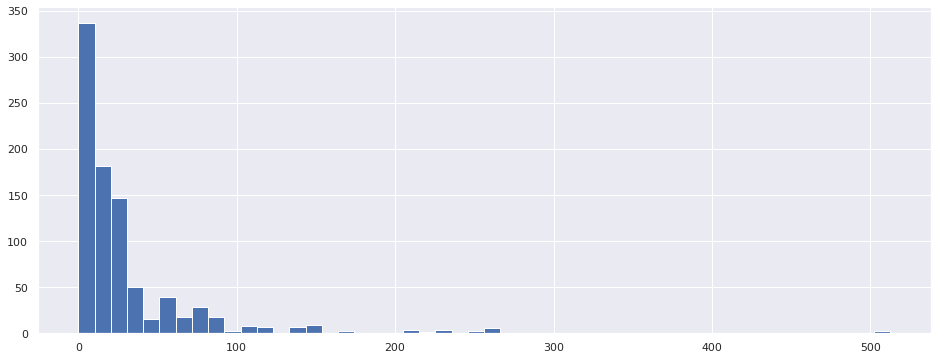

In [211]:
# Histogramme de La variable continue Fare
data['Fare'].hist(bins=50, figsize=(16,6))

Text(0.5, 1.0, 'Boxplot')

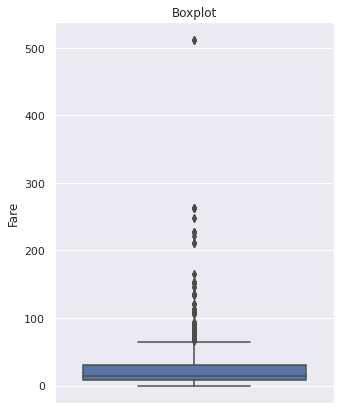

In [212]:
# boxplot - Fare
plt.figure(figsize=(5,7))
sns.boxplot(y=data['Fare'])
plt.title('Boxplot')

- #### Variable SibSp

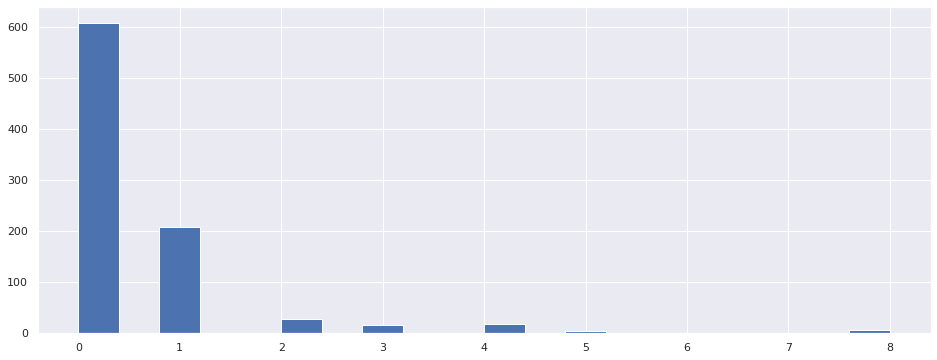

In [213]:
#histogramme de variables discrètes
data['SibSp'].hist(bins=20, figsize=(16,6))

Text(0.5, 1.0, 'Boxplot')

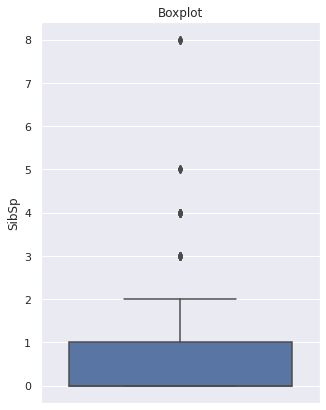

In [214]:
# boxplot - SibSp

plt.figure(figsize=(5,7))
sns.boxplot(y=data['SibSp'])
plt.title('Boxplot')

- #### Relations entre les colonnes

In [215]:
# define a function to plot relation between columns
def dist(feature,title):
    survived = data[data['Survived']==1][feature].value_counts()
    dead = data[data['Survived']==0][feature].value_counts()
    df = pd.DataFrame([survived,dead])
    df.index = ['Survecu','mort']
    df.plot(kind='bar',stacked=True)
    plt.title(title)
    plt.show()

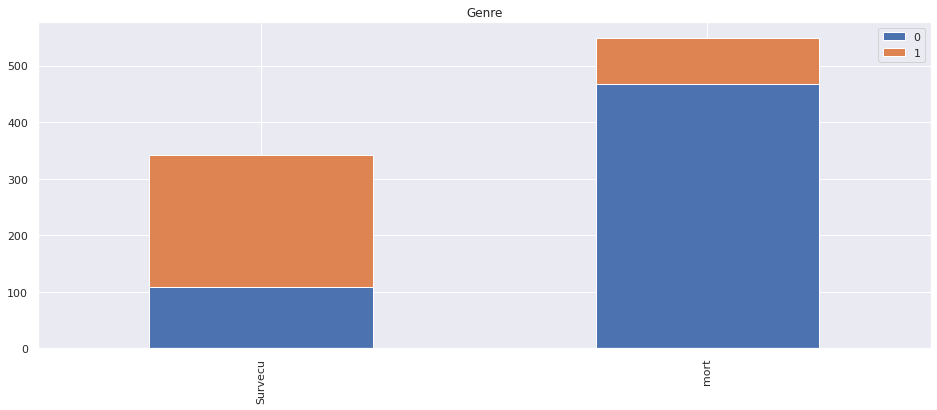

In [216]:
# Sex et Survived
dist('Sex','Genre')

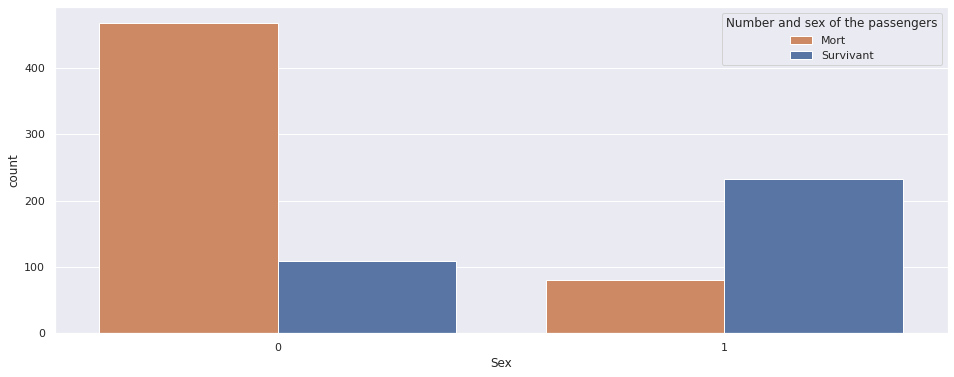

In [217]:
x = sns.countplot(x = "Sex", hue = "Survived", data = data, palette=["C1", "C0"]).legend(labels = ["Mort", "Survivant"])
x.set_title("Number and sex of the passengers")

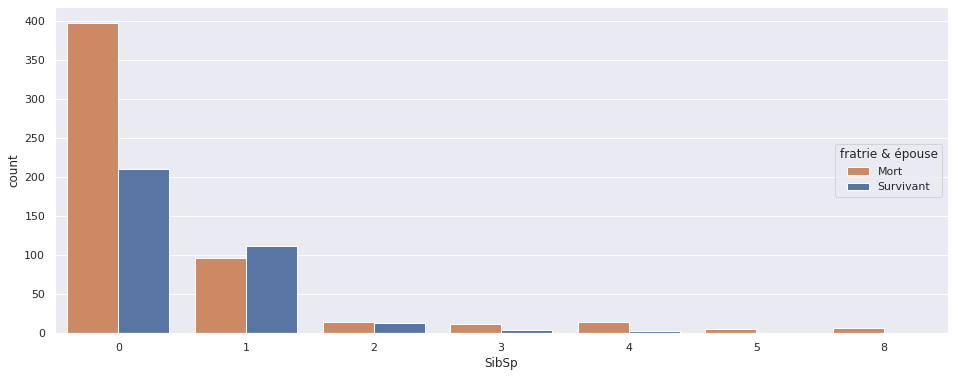

In [218]:
# SibSp et Survived
x = sns.countplot(x = "SibSp", hue = "Survived", data = data, palette=["C1", "C0"]).legend(labels = ["Mort", "Survivant"],loc='center right')
x.set_title("fratrie & épouse")

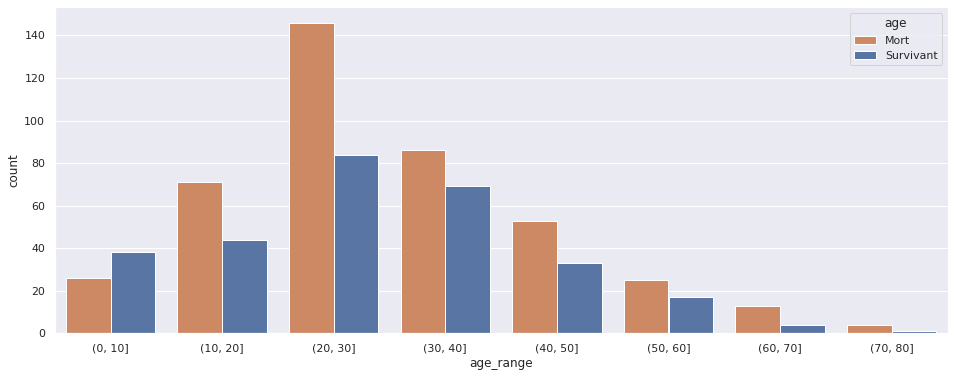

In [219]:
# Age et Survived
x = sns.countplot(x = "age_range", hue = "Survived", data = data, palette=["C1", "C0"]).legend(labels = ["Mort", "Survivant"])
x.set_title("age")

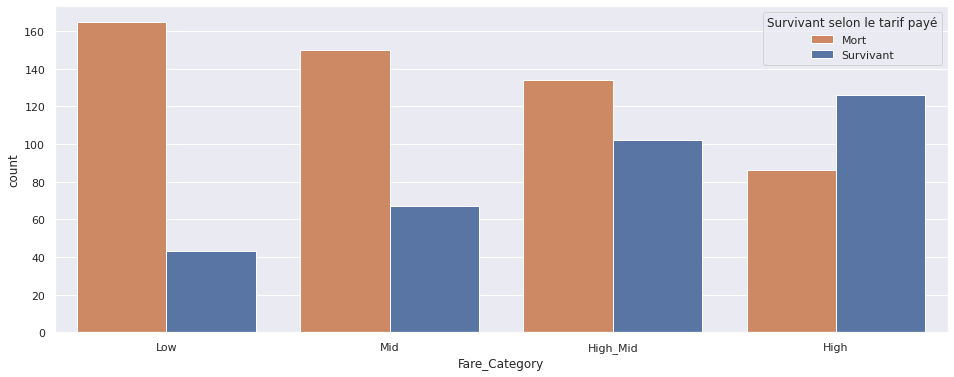

In [220]:
data['Fare_Category'] = pd.cut(data['Fare'], bins=[0,7.90,14.45,31.28,265], labels=['Low','Mid','High_Mid','High'])
x = sns.countplot(x = "Fare_Category", hue = "Survived", data = data, palette=["C1", "C0"]).legend(labels = ["Mort", "Survivant"])
x.set_title("Survivant selon le tarif payé")

Text(0, 0.5, 'Nombre de passagers')

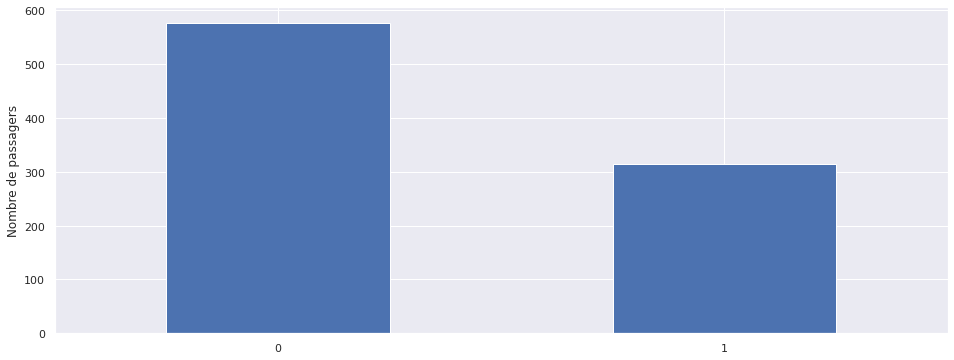

In [221]:
# bar plot de variables catégorielles Embarked dans notre cas
data['Embarked'].value_counts().plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Nombre de passagers')

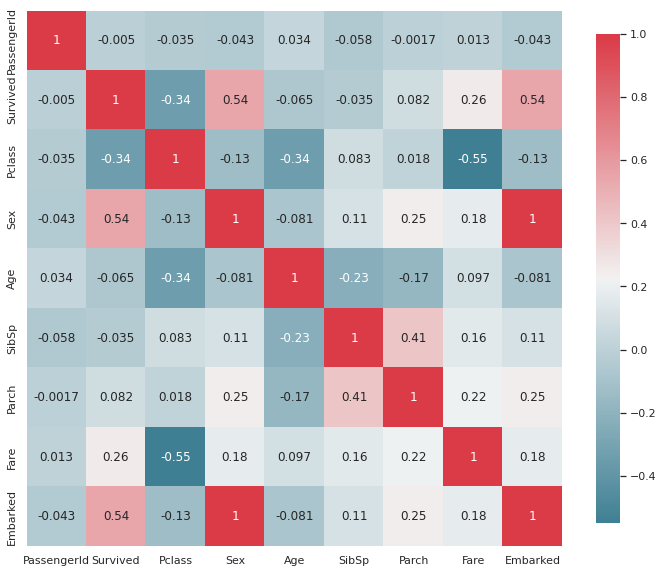

In [222]:
def plot_correlation_map( df ):
    corr = df.corr()
    s , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette(220 , 10 , as_cmap = True )
    s = sns.heatmap(
        corr,
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
        )
    
plot_correlation_map( data )

La carte de corrélation ci-dessus montre les coefficients de corrélation entre plusieurs variables ou caractéristiques. Elle est parfaitement symétrique.
- on remarque que la corrélation entre « pclass » et « fare » est de -0,56, ce qui indique qu'ils sont fortement corrélés négativement. Une classe supérieure est fortement liée à un tarif inférieur.
- La corrélation entre "SibSp" et "Pclass" est de 0,061, ce qui indique qu'ils ne sont fondamentalement pas corrélés.
- On remarque aussi que les coefficients de corrélation le long de la diagonale du tableau sont tous égaux à 1 car chacun variable est parfaitement corrélée à elle-même.
- conclusion : Il serait très difficile de comprendre la relation entre chaque variable en regardant simplement les données brutes.
- Une carte de corrélation peut nous aider à comprendre rapidement les corrélations entre chaque paire de variables.

In [223]:
data = pd.read_csv('/content/drive/MyDrive/Dossier_sans_titre/train.csv', sep=",",index_col=False)
drop_list=['Cabin','Ticket','PassengerId','Fare','SibSp','Parch', 'Name']
data = data.drop(drop_list,axis=1)
#filling the missing Embarked values in train and test datasets
data.Embarked.fillna('S',inplace=True)
#filling the missing values in the Age column
data.Age.fillna(28, inplace=True)
data.Sex = data.Sex.replace([['male'],['female']],[0,1])
data.Embarked = data.Embarked.replace([['C'],['Q'],['S']],[1,2,3])


def normalize_data(X ):
  scaler = StandardScaler()
  scaler.fit(X)
 
  X_train = scaler.transform(X)
  return X_train

In [247]:
X = data.drop("Survived",axis=1)
y = data["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


start_time = time.time()


#Training accuracy score before normalization

mlp = MLPClassifier(activation='relu', hidden_layer_sizes = (131,121,150), solver = 'sgd' , max_iter = 200,  random_state=0)
mlp.fit(X_train, y_train)

proba = mlp.predict_proba(X_test)
proba1 = mlp.predict(X_test)

print('le score avant la normalisation est de : ',accuracy_score(y_test, mlp.predict(X_test)))
print("--- %s seconds ---" % (time.time() - start_time))




le score avant la normalisation est de :  0.8100558659217877
--- 3.893268585205078 seconds ---


In [248]:
#Training accuracy score  after normalization 
X_train = normalize_data(X_train)
X_test  = normalize_data(X_test)
 
start_time = time.time()
mlp.fit(X_train, y_train)

proba = mlp.predict_proba(X_test)
proba1 = mlp.predict(X_test)

print('le score aprés la normalisation est de : ',accuracy_score(y_test, mlp.predict(X_test)))
print("--- %s seconds ---" % (time.time() - start_time))

le score aprés la normalisation est de :  0.8212290502793296
--- 3.18985915184021 seconds ---
